In [2]:
import numpy as np 
import tables
import matplotlib.pyplot as plt
import os
import pickle

In [3]:
f_dir = 'test_model'
rep = 0
lr = 0.02

stim_st_time = 45
target_st_time = 25

In [4]:
def relu(input):
    return input * (input>0)

with open(os.path.join(f_dir, 'init_weight_%d_lr%f.pth'%(rep, lr)), 'rb') as f:
    w_init = np.load(f,allow_pickle=True)
with open(os.path.join(f_dir, 'model_results_%d_lr%f.pkl'%(rep, lr)), 'rb') as f:
    model_results =  pickle.load(f)
train_output = tables.open_file(os.path.join(f_dir, 'train_output_lr%f_rep%d.h5'%(lr, rep)), mode = 'r')
test_output = tables.open_file(os.path.join(f_dir, 'test_output_lr%f_rep%d.h5'%(lr, rep)), mode = 'r')
train_table = train_output.root
test_table = test_output.root
w_init = w_init.item()

FileNotFoundError: [Errno 2] No such file or directory: 'test_model\\init_weight_0_lr0.020000.pth'

In [5]:
test_table

/ (RootGroup) 'Test output'
  children := ['h_iter0' (Array), 'neural_in_iter0' (Array), 'rt_iter0' (Array), 'stim_dir_iter0' (Array), 'stim_level_iter0' (Array), 'target_iter0' (Array), 'y_hist_iter0' (Array)]

In [1]:
all_iters = []
for row in train_table:
    iter_num = int(row.name.split('iter')[1])
    if iter_num not in all_iters:
        all_iters.append(iter_num)
    else:
        break
max_iter = max(all_iters)
print(max_iter)


NameError: name 'train_table' is not defined

## Plot and Save Single Cell Activity

### Functions

In [34]:
def find_cell_group(cell_idx):
    grp = ''
    if cell_idx in range(160):
        grp += 'Exc'
        if cell_idx in range(80):
            grp += '_Contra'
            if cell_idx in range(32):
                grp += '_Motion'
            else:
                grp += '_Target'
        else:
            grp += '_Ipsi'
            if cell_idx in range(80, 112):
                grp += '_Motion'
            else:
                grp += '_Target'
       
    else:
        grp += 'Inh'
        if cell_idx in range(160, 180):
            grp += '_Contra'
            if cell_idx in range(160, 168):
                grp += '_Motion'
            else:
                grp += '_Target'
        else:
            grp += '_Ipsi'
            if cell_idx in range(180, 188):
                grp += '_Motion'
            else:
                grp += '_Target'
    return grp

In [35]:
def find_coh_idx(stim_level):
    H_idx = np.array(stim_level)==b'H'
    M_idx = np.array(stim_level)==b'M'
    L_idx = np.array(stim_level)==b'L'
    Z_idx = np.array(stim_level)==b'Z'
    return H_idx, M_idx, L_idx, Z_idx

def find_sac_idx(y):
    choice = np.argmax(y, 2)
    contra_idx = choice==0
    ipsi_idx = choice==1
    return contra_idx, ipsi_idx

def recover_targ_loc(desired_out, stim_dir):
    # return the target arrangement: green_contra = 0, red_contra = 1
    choice = np.argmax(desired_out, 2)
    target = choice==1 # contra = 0, ipsi = 1
    dir = stim_dir==315 # green = 0, red = 1
    return np.logical_xor(target, dir)

def get_choice_color(y, desired_out, stim_dir):
    # return choice color (green = 0, red = 1)
    choice = np.argmax(y, 2)
    targ_loc = recover_targ_loc(desired_out, stim_dir)
    return np.logical_xor(choice, targ_loc)

def find_pref_dir(stim_dir, h):
    red_idx = stim_dir==315
    green_idx = stim_dir==135
    red_mean = np.mean(h[stim_st_time:, red_idx, :], axis=[0, 1])
    green_mean = np.mean(h[stim_st_time:, green_idx, :], axis=[0, 1])
    pref_red = red_mean>green_mean
    return pref_red

def calc_avg_idx(h, trial_idx, cell_idx):
    return np.mean(h[:, trial_idx, cell_idx], axis=[1, 2])

def find_correct_idx(y, desired_output, Z_idx):
    target_max = np.argmax(desired_output, axis=2)[-1, :]
    output_max = np.argmax(y, axis=2)[-1, :]
    return (target_max == output_max + Z_idx)

def find_coh_idx(stim_level):
    H_idx = np.array(stim_level)==b'H'
    M_idx = np.array(stim_level)==b'M'
    L_idx = np.array(stim_level)==b'L'
    Z_idx = np.array(stim_level)==b'Z'
    return H_idx, M_idx, L_idx, Z_idx

def find_sac_idx(y):
    choice = np.argmax(y, 2)
    contra_idx = choice==0
    ipsi_idx = choice==1
    return contra_idx, ipsi_idx

def recover_targ_loc(desired_out, stim_dir):
    # return the target arrangement: green_contra = 0, red_contra = 1
    choice = np.argmax(desired_out, 2)
    target = choice==1 # contra = 0, ipsi = 1
    dir = stim_dir==315 # green = 0, red = 1
    return np.logical_xor(target, dir)

def get_choice_color(y, desired_out, stim_dir):
    # return choice color (green = 0, red = 1)
    choice = np.argmax(y, 2)
    targ_loc = recover_targ_loc(desired_out, stim_dir)
    return np.logical_xor(choice, targ_loc)

def find_pref_dir(stim_dir, h):
    red_idx = stim_dir==315
    green_idx = stim_dir==135
    red_mean = np.mean(h[stim_st_time:, red_idx, :], axis=[0, 1])
    green_mean = np.mean(h[stim_st_time:, green_idx, :], axis=[0, 1])
    pref_red = red_mean>green_mean
    return pref_red

def calc_avg_idx(h, trial_idx, cell_idx):
    return np.mean(h[:, trial_idx, cell_idx], axis=[1, 2])

def find_correct_idx(y, desired_output):
    target_max = np.argmax(desired_output, axis=2)[-1, :]
    output_max = np.argmax(y, axis=2)[-1, :]
    return (target_max == output_max)

def combine_idx(*args):
    temp = args[0]
    for i in range(1, len(args)):
        temp = np.logical_and(temp, args[i])
    return temp  

def plot_coh_avgAct(h, y, desired_out, stim_level, stim_dir, cell_idx, save_plt):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize =(10, 4))
    H_idx, M_idx, L_idx, Z_idx = find_coh_idx(stim_level)
    red_idx = stim_dir==315
    green_idx = stim_dir==135
    choice_color = get_choice_color(y, desired_out, stim_dir)
    contra_idx, ipsi_idx = find_sac_idx(y)
    correct_idx = find_correct_idx(y, desired_out)

    # zero coherence stimulus direction is based on the choice color
    ax1.plot(np.mean(h[:, combine_idx(ipsi_idx[-1, :], Z_idx, choice_color[-1, :]==0), cell_idx], axis=1), linestyle ='--', color='#000000', label='135, Z')
    ax1.plot(np.mean(h[:, combine_idx(ipsi_idx[-1, :], L_idx, correct_idx, green_idx), cell_idx], axis=1), color='#046C41', label='135, L')
    ax1.plot(np.mean(h[:, combine_idx(ipsi_idx[-1, :], M_idx, correct_idx, green_idx), cell_idx], axis=1), color='#1AA33C', label='135, M')
    ax1.plot(np.mean(h[:, combine_idx(ipsi_idx[-1, :], H_idx, correct_idx, green_idx), cell_idx], axis=1), color='#83D475', label='135, H')
    ax1.plot(np.mean(h[:, combine_idx(ipsi_idx[-1, :], Z_idx, correct_idx, choice_color[-1, :]==1), cell_idx], axis=1), color='#000000', label='315, Z')
    ax1.plot(np.mean(h[:, combine_idx(ipsi_idx[-1, :], L_idx, correct_idx, red_idx), cell_idx], axis=1), color='#910000', label='315, L')
    ax1.plot(np.mean(h[:, combine_idx(ipsi_idx[-1, :], M_idx, correct_idx, red_idx), cell_idx], axis=1), color='#D32431', label='315, M')
    ax1.plot(np.mean(h[:, combine_idx(ipsi_idx[-1, :], H_idx, correct_idx, red_idx), cell_idx], axis=1), color='#CE5757', label='315, H')
    ax1.set_title("Ipsi-lateral Saccade")
    ax1.set_ylabel("Average activity")
    ax1.set_xlabel("Time")
    ax1.legend()
    ax1.axvline(x=target_st_time, color='k')
    ax1.axvline(x=stim_st_time, color='k')

    ax2.plot(np.mean(h[:, combine_idx(contra_idx[-1, :], Z_idx, choice_color[-1, :]==0), cell_idx], axis=1), linestyle ='--', color='#000000', label='135, Z')
    ax2.plot(np.mean(h[:, combine_idx(contra_idx[-1, :], L_idx, correct_idx, green_idx), cell_idx], axis=1), color='#046C41', label='135, L')
    ax2.plot(np.mean(h[:, combine_idx(contra_idx[-1, :], M_idx, correct_idx, green_idx), cell_idx], axis=1), color='#1AA33C', label='135, M')
    ax2.plot(np.mean(h[:, combine_idx(contra_idx[-1, :], H_idx, correct_idx, green_idx), cell_idx], axis=1), color='#83D475', label='135, H')
    ax2.plot(np.mean(h[:, combine_idx(contra_idx[-1, :], Z_idx, choice_color[-1, :]==1), cell_idx], axis=1), color='#000000', label='315, Z')
    ax2.plot(np.mean(h[:, combine_idx(contra_idx[-1, :], L_idx, correct_idx, red_idx), cell_idx], axis=1), color='#910000', label='315, L')
    ax2.plot(np.mean(h[:, combine_idx(contra_idx[-1, :], M_idx, correct_idx, red_idx), cell_idx], axis=1), color='#D32431', label='315, M')
    ax2.plot(np.mean(h[:, combine_idx(contra_idx[-1, :], H_idx, correct_idx, red_idx), cell_idx], axis=1), color='#CE5757', label='315, H')
    ax2.set_title("Contra-lateral Saccade")
    ax2.set_ylabel("Average activity")
    ax2.set_xlabel("Time")
    ax2.legend()
    ax2.axvline(x=target_st_time, color='k')
    ax2.axvline(x=stim_st_time, color='k')

    plt.suptitle('Cell %d, %s'% (cell_idx, find_cell_group(cell_idx)))

    if save_plt:
        pic_dir = os.path.join(f_dir, 'single_neuron_activity_rep%d_lr%f' %(rep, lr))
        if not os.path.exists(pic_dir):
            os.makedirs(pic_dir)
        plt.savefig(os.path.join(pic_dir,'cell_%d.png'% cell_idx))
        plt.close(fig)


### Run Results

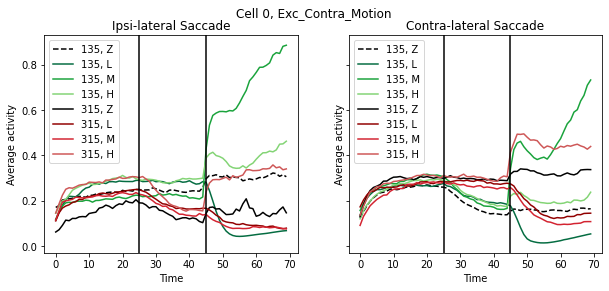

In [36]:
h = table['h_iter%d' %max_iter][:]
y = table['y_hist_iter%d' %max_iter][:]
desired_out = table['target_iter%d' %max_iter][:]
stim_level = table['stim_level_iter%d' %max_iter][:]
stim_dir = table['stim_dir_iter%d' %max_iter][:]

plot_coh_avgAct(h, y, desired_out, stim_level, stim_dir, 0, False)

In [37]:
for i in range(200):
    plot_coh_avgAct(h, y, desired_out, stim_level, stim_dir, i, True)

## Plot Population Activities

### Functions

In [38]:
def find_pref_dir(stim_dir, h):
    red_idx = stim_dir==315
    green_idx = stim_dir==135
    red_mean = np.mean(h[stim_st_time:, red_idx, :], axis=(0, 1))
    green_mean = np.mean(h[stim_st_time:, green_idx, :], axis=(0, 1))
    pref_red = red_mean>green_mean
    return pref_red
    
def plot_population_activity(h, y, desired_out, stim_level, stim_dir, title, save_plt):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize =(10, 4))
    H_idx, M_idx, L_idx, Z_idx = find_coh_idx(stim_level)
    # find the trial of preferred direction
    pref_red = find_pref_dir(stim_dir, h)
    dir_red = stim_dir==315
    pref_red_temp = np.tile(pref_red, (len(dir_red), 1))
    dir_red_temp = np.tile(np.reshape(dir_red, (-1, 1)), (1, len(pref_red)))
    pref_dir = pref_red_temp == dir_red_temp
    pref_mask = np.broadcast_to(pref_dir[None, :, :], h.shape)    

    contra_idx, ipsi_idx = find_sac_idx(y)
    correct_idx = find_correct_idx(y, desired_out)

    # zero coherence stimulus direction is based on the choice color
    
    ax1.plot(np.mean(h[:,(pref_dir + np.broadcast_to(combine_idx(ipsi_idx[-1, :], Z_idx)[:, None], pref_dir.shape))==0], axis=1), linestyle ='--', color='k', label='nonPref, Z')
    ax1.plot(np.mean(h[:,(pref_dir + np.broadcast_to(combine_idx(ipsi_idx[-1, :], L_idx, correct_idx)[:, None], pref_dir.shape))==0], axis=1), linestyle ='--', color='b', label='nonPref, L')
    ax1.plot(np.mean(h[:,(pref_dir + np.broadcast_to(combine_idx(ipsi_idx[-1, :], M_idx, correct_idx)[:, None], pref_dir.shape))==0], axis=1), linestyle ='--', color='g', label='nonPref, M')
    ax1.plot(np.mean(h[:,(pref_dir + np.broadcast_to(combine_idx(ipsi_idx[-1, :], H_idx, correct_idx)[:, None], pref_dir.shape))==0], axis=1), linestyle ='--', color='r', label='nonPref, H')
    ax1.plot(np.mean(h[:,(pref_dir + np.broadcast_to(combine_idx(ipsi_idx[-1, :], Z_idx)[:, None], pref_dir.shape))==1], axis=1), color='k', label='Pref, Z')
    ax1.plot(np.mean(h[:,(pref_dir + np.broadcast_to(combine_idx(ipsi_idx[-1, :], L_idx, correct_idx)[:, None], pref_dir.shape))==1], axis=1), color='b', label='Pref, L')
    ax1.plot(np.mean(h[:,(pref_dir + np.broadcast_to(combine_idx(ipsi_idx[-1, :], M_idx, correct_idx)[:, None], pref_dir.shape))==1], axis=1), color='g', label='Pref, M')
    ax1.plot(np.mean(h[:,(pref_dir + np.broadcast_to(combine_idx(ipsi_idx[-1, :], H_idx, correct_idx)[:, None], pref_dir.shape))==1], axis=1), color='r', label='Pref, H')
    ax1.set_title("Ipsi-lateral Saccade")
    ax1.set_ylabel("Average activity")
    ax1.set_xlabel("Time")
    ax1.axvline(x=target_st_time, color='k')
    ax1.axvline(x=stim_st_time, color='k')

    ax2.plot(np.mean(h[:,(pref_dir + np.broadcast_to(combine_idx(contra_idx[-1, :], Z_idx)[:, None], pref_dir.shape))==0], axis=1), linestyle ='--', color='k', label='nonPref, Z')
    ax2.plot(np.mean(h[:,(pref_dir + np.broadcast_to(combine_idx(contra_idx[-1, :], L_idx, correct_idx)[:, None], pref_dir.shape))==0], axis=1), linestyle ='--', color='b', label='nonPref, L')
    ax2.plot(np.mean(h[:,(pref_dir + np.broadcast_to(combine_idx(contra_idx[-1, :], M_idx, correct_idx)[:, None], pref_dir.shape))==0], axis=1), linestyle ='--', color='g', label='nonPref, M')
    ax2.plot(np.mean(h[:,(pref_dir + np.broadcast_to(combine_idx(contra_idx[-1, :], H_idx, correct_idx)[:, None], pref_dir.shape))==0], axis=1), linestyle ='--', color='r', label='nonPref, H')
    ax2.plot(np.mean(h[:,(pref_dir + np.broadcast_to(combine_idx(contra_idx[-1, :], Z_idx)[:, None], pref_dir.shape))==1], axis=1), color='k', label='Pref, Z')
    ax2.plot(np.mean(h[:,(pref_dir + np.broadcast_to(combine_idx(contra_idx[-1, :], L_idx, correct_idx)[:, None], pref_dir.shape))==1], axis=1), color='b', label='Pref, L')
    ax2.plot(np.mean(h[:,(pref_dir + np.broadcast_to(combine_idx(contra_idx[-1, :], M_idx, correct_idx)[:, None], pref_dir.shape))==1], axis=1), color='g', label='Pref, M')
    ax2.plot(np.mean(h[:,(pref_dir + np.broadcast_to(combine_idx(contra_idx[-1, :], H_idx, correct_idx)[:, None], pref_dir.shape))==1], axis=1), color='r', label='Pref, H')
    ax2.set_title("Contra-lateral Saccade")
    ax2.set_ylabel("Average activity")
    ax2.set_xlabel("Time")
    ax2.legend()
    ax2.axvline(x=target_st_time, color='k')
    ax2.axvline(x=stim_st_time, color='k')

    plt.suptitle(title)

    if save_plt:
        pic_dir = os.path.join(f_dir, 'population_neuron_activity_rep%d_lr%f' %(rep, lr))
        if not os.path.exists(pic_dir):
            os.makedirs(pic_dir)
        plt.savefig(os.path.join(pic_dir,'%s.png'% title))
        plt.close(fig) 

def min_max_normalize(arr):
    return (arr - np.min(arr))/(np.max(arr) - np.min(arr))   


### Run Results

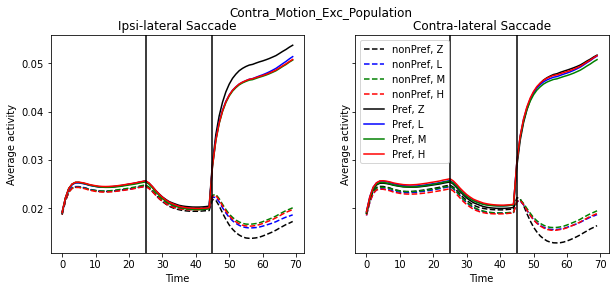

In [39]:

normalized_h = np.zeros(h.shape)
for i in range(h.shape[2]):
    normalized_h[:, :, i] = min_max_normalize(h[:, :, i])
temp_h = normalized_h[:, :, :32]
plot_population_activity(temp_h, y, desired_out, stim_level, stim_dir, 'Contra_Motion_Exc_Population', False)

In [40]:
temp_h = normalized_h[:, :, :32]
plot_population_activity(temp_h, y, desired_out, stim_level, stim_dir, 'Contra_Motion_Exc_Population', True)
temp_h = normalized_h[:, :, 32:80]
plot_population_activity(temp_h, y, desired_out, stim_level, stim_dir, 'Contra_Target_Exc_Population', True)
temp_h = normalized_h[:, :, 80:112]
plot_population_activity(temp_h, y, desired_out, stim_level, stim_dir, 'Ipsi_Motion_Exc_Population', True)
temp_h = normalized_h[:, :, 112:160]
plot_population_activity(temp_h, y, desired_out, stim_level, stim_dir, 'Ipsi_Target_Exc_Population', True)

temp_h = normalized_h[:, :, 160:168]
plot_population_activity(temp_h, y, desired_out, stim_level, stim_dir, 'Contra_Motion_Inh_Population', True)
temp_h = normalized_h[:, :, 168:180]
plot_population_activity(temp_h, y, desired_out, stim_level, stim_dir, 'Contra_Target_Inh_Population', True)
temp_h = normalized_h[:, :, 180:188]
plot_population_activity(temp_h, y, desired_out, stim_level, stim_dir, 'Ipsi_Motion_Inh_Population', True)
temp_h = normalized_h[:, :, 188:200]
plot_population_activity(temp_h, y, desired_out, stim_level, stim_dir, 'Ipsi_Target_Inh_Population', True)


## Proportion of Explained Variances

In [18]:
def calculate_fev(h0, left_ind, right_ind):

    h0_cut = np.dstack([h0[i:1+i-5 or None:1] for i in range(5)])
    gm = np.mean(h0_cut, axis=(1, 2))
    # left_mean = np.mean(h0_cut[:,left_ind,:], axis=(1, 2))
    # right_mean = np.mean(h0_cut[:,right_ind,:], axis=(1, 2))

    left_mean = np.mean(h0_cut[:,left_ind,:], axis=(1, 2))
    right_mean = np.mean(h0_cut[:,right_ind,:], axis=(1, 2))

    ssq_total = np.sum(np.square(h0_cut - gm[:, None, None]), axis=(1, 2))
    ssq_cond = sum(left_ind) * np.square(left_mean - gm) + \
                sum(right_ind) * np.square(right_mean - gm)
    
    mse = (ssq_total - ssq_cond) / (h0_cut.shape[1] - 2)
    fev = (ssq_cond-mse)/(ssq_total+mse)
    return fev

def plot_cell_fev(h, y, stim_dir, save_plt):
    contra_idx, ipsi_idx = find_sac_idx(y)
    temp_h = np.transpose(h, (2, 0, 1))
    all_fev_saccade = list(map(lambda h0: calculate_fev(h0, contra_idx[-1, :], ipsi_idx[-1, :]), temp_h))
    all_fev_motion = list(map(lambda h0: calculate_fev(h0, stim_dir==315, stim_dir==135), temp_h))

    for i in range(h.shape[2]):
        plt.plot(all_fev_saccade[i], label='saccade')
        plt.plot(all_fev_motion[i], label='motion')
        plt.title('FEV of cell %d, %s'%(i, find_cell_group(i)))
        plt.legend()
        plt.axvline(target_st_time - 2.5, color='black')
        plt.axvline(stim_st_time - 2.5, color='black')
        if save_plt:
            pic_dir = os.path.join(f_dir, 'single_neuron_fev')
            if not os.path.exists(pic_dir):
                os.makedirs(pic_dir)
            plt.savefig(os.path.join(pic_dir,'cell_%d.png'% i))
            plt.close()

In [19]:
normalized_h = np.zeros(h.shape)
for i in range(h.shape[2]):
    normalized_h[:, :, i] = min_max_normalize(h[:, :, i])
plot_cell_fev(normalized_h, y, stim_dir, True)

In [22]:
h0 = h[:, :, 0]
h0_cut = np.dstack([h0[i:1+i-5 or None:1] for i in range(5)])
h0_cut.shape

(66, 2048, 5)

In [26]:
contra_idx.shape

(70, 2048)

In [18]:
h0.shape

(70, 2048)

In [20]:
h0[1:6].shape

(5, 2048)

In [ ]:
train_output.close()